# Regression maps
The regression between sea level (zos) and wind stress curl (wsc) over the tropical Pacific region.

In [2]:
import os
import cftime
import dask
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, processes=False)
client

/storage1/home1/chiaweih/anaconda2/envs/python3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: scheduler='inproc://128.196.236.68/27340/1' processes=1 cores=8>

In [3]:
import warnings
warnings.simplefilter("ignore")

from mem_track import used_memory
used_memory()

used 164.480469 MB


# Model

In [4]:
#### possible input info from external text file
# constant setting
syear = 1958            
fyear = 2007
tp_lat_region = [-30,30]     # extract model till latitude

Model_varname = ['tauuo','tauvo','zos']
Area_name = ['areacello_cu','areacello_cv','areacello']

Model_name = ['JRA','CORE']
Model_legend_name = ['JRA55-do','CORE']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'zos'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = 'JRA_zos.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_tauuo.zarr'],['JRA_tauvo.zarr'],['JRA_zos.zarr']]
path[model]=[modeldir,modelfile]

model = Model_name[1]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
modelfile = [['CORE_tauuo.zarr'],['CORE_tauvo.zarr'],['CORE_zos.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [5]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist = {}
mean_mlist = {}
season_mlist = {}
linear_mlist = {}

In [6]:
#### models
import sys
import importlib
import xr_ufunc
importlib.reload(xr_ufunc)
from xr_ufunc import da_linregress

for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear)&\
                                 (ds_model['time.year'] <= fyear)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
        # remove linear trend 
        linear_list[var] = da_linregress(ds_model_list[var],stTconfint=0.99) 

    linear_mlist[model] = linear_list
    mean_mlist[model] = mean_list
    season_mlist[model] = season_list
    ds_model_mlist[model] = ds_model_list

read JRA tauuo
read JRA tauvo
read JRA zos
read CORE tauuo
read CORE tauvo
read CORE zos


In [7]:
# detrend 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        da_time = ds_model_mlist[model][var].time.copy()
        year = ds_model_mlist[model][var]['time.year'].values
        month = ds_model_mlist[model][var]['time.month'].values
        da_time.values = year+month/12.
        ds_model_mlist[model][var] = ds_model_mlist[model][var]-\
                                     (da_time*linear_mlist[model][var]['slope']+linear_mlist[model][var]['intercept'])

In [8]:
used_memory()

used 13105.308594 MB


In [9]:
# import importlib
# import xr_ufunc
# importlib.reload(xr_ufunc)
# from xr_ufunc import da_var_detrend_3d

# ds_model_list[var] = da_var_detrend_3d(ds_model_list[var])

# Regridding

In [10]:
#### models
da_model_standard = xr.open_zarr(path_standard).isel(time=0).load()     

da_model_standard = da_model_standard\
                  .where((da_model_standard.lat >= np.min(np.array(tp_lat_region)))&\
                         (da_model_standard.lat <= np.max(np.array(tp_lat_region)))\
                         ,drop=True)

In [11]:
import importlib
import create_ocean_mask
importlib.reload(create_ocean_mask)
from create_ocean_mask import levitus98

# # calculate zonal mean in the Pacific Basin
# from create_ocean_mask import levitus98

da_pacific = levitus98(da_model_standard,
                       basin=['pac'],
                       reuse_weights=True, 
                       newvar=True, 
                       lon_name='x',
                       lat_name='y', 
                       new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


# El Nino

In [12]:
# noi
path = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/regional_avg/'
file = 'JRA_tos_oni_ts.nc'
ds_oni = xr.open_dataset(path+file)

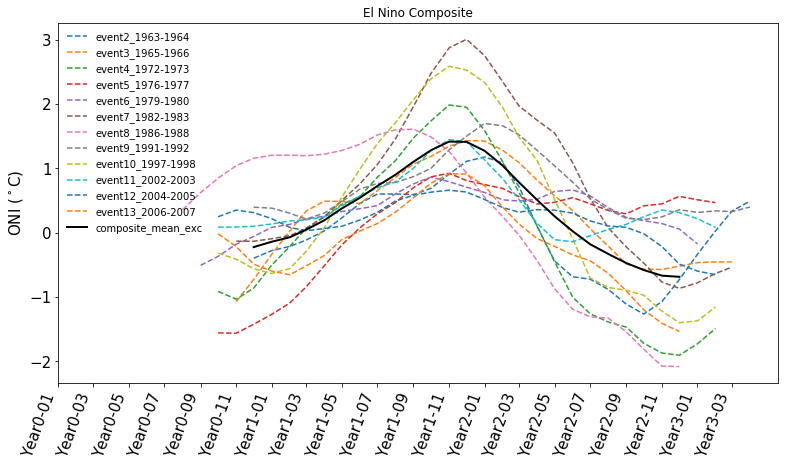

In [13]:
import importlib
import enso_composite
importlib.reload(enso_composite)

from enso_composite import elnino_composite

ds_oni_comp = elnino_composite(ds_oni.oni,syear,fyear,premon=13,postmon=15,period_type='maxval',exclude=[1])

In [29]:
import importlib
import enso_composite
importlib.reload(enso_composite)
from enso_composite import proc_elnino_composite_maps

elninocomp_mlist = {}
for nmodel,model in enumerate(Model_name):
    elninocomp_list = {}
    for nvar,var in enumerate(Model_varname):
        elninocomp_list[var] = proc_elnino_composite_maps(ds_oni.oni,
                                                        ds_model_mlist[model][var],
                                                        syear,
                                                        fyear,
                                                        premon=13,
                                                        postmon=15,
                                                        period_type='maxval',
                                                        exclude=[1])
    elninocomp_mlist[model] = elninocomp_list

12
12
12
12
12
12


In [15]:
import xesmf as xe

# Regridding to the tracer points
regridder_mlist = {}
for nmodel,model in enumerate(Model_name):
    regridder_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            regridder = xe.Regridder(ds_model_mlist[model][var],
                                     da_model_standard,
                                     'bilinear',
                                     filename='%s_%s2%s_%s.nc'%(model,var,Model_standard,Variable_standard),
                                     periodic=True,
                                     reuse_weights=False)
            regridder_list['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[model] = regridder_list
    
    

# v2t.clean_weight_file() 
# u2t.clean_weight_file()

Overwrite existing file: JRA_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: JRA_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
model variable same as standard model variable
Overwrite existing file: CORE_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_zos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [30]:
#### regridding elnino composite field 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            elninocomp_mlist[model][var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)](elninocomp_mlist[model][var])
            elninocomp_mlist[model][var]['x'] = da_model_standard.x.values
            elninocomp_mlist[model][var]['y'] = da_model_standard.y.values

model variable same as standard model variable


# Derive Ekman upwelling/downwelling and wind stress curl

In [31]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import curl_tau_3d, ekman_pumping2_3d


for nmodel,model in enumerate(Model_name):
    elninocomp_mlist[model]['Ek_tauuo'],elninocomp_mlist[model]['Ek_tauvo'] = ekman_pumping2_3d(
                                                      elninocomp_mlist[model]['tauuo'],
                                                      elninocomp_mlist[model]['tauvo'],
                                                      eq_mask=True)
    elninocomp_mlist[model]['curl_tauuo'],elninocomp_mlist[model]['curl_tauvo'] = curl_tau_3d(
                                               elninocomp_mlist[model]['tauuo'],
                                               elninocomp_mlist[model]['tauvo'])

In [32]:
import importlib
import xr_ufunc
importlib.reload(xr_ufunc)
from xr_ufunc import linregress_3d

regress_mlist = {}
for nmodel,model in enumerate(Model_name):
    elninocomp_mlist[model]['curl_tau']=elninocomp_mlist[model]['curl_tauuo']+elninocomp_mlist[model]['curl_tauvo']
    regress_mlist[model] = linregress_3d(elninocomp_mlist[model]['curl_tau'],
                                         elninocomp_mlist[model]['zos'],
                                         dim='time')

# Plotting 

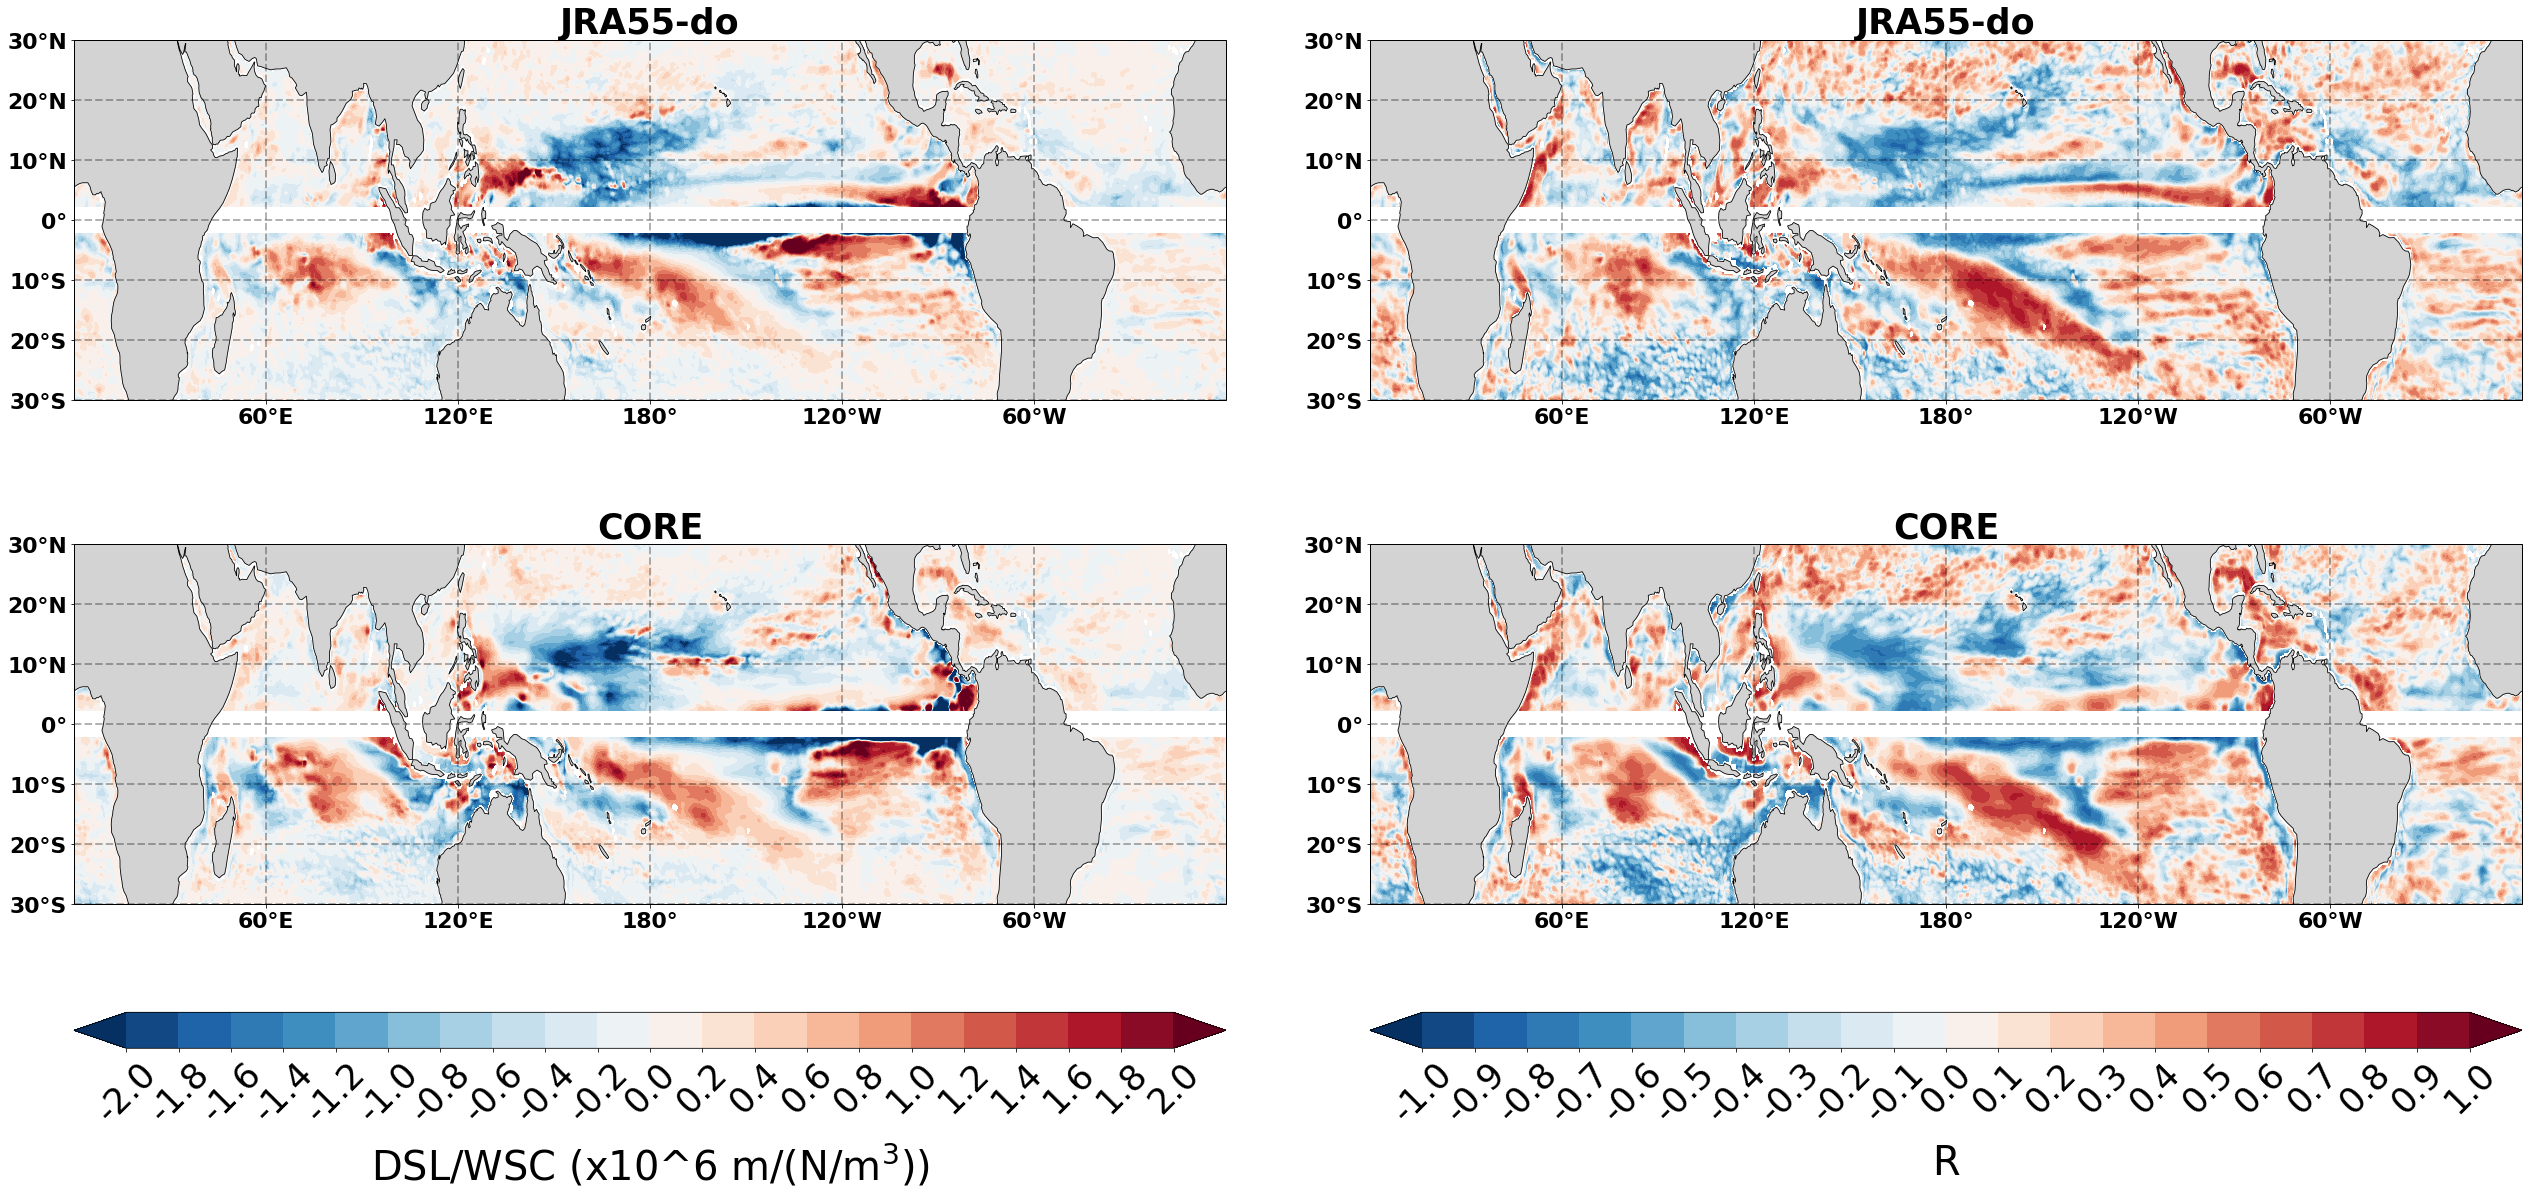

In [34]:
# comparing tau curl
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7

for nmodel, model in enumerate(Model_name):

    #### plotting
    level=np.linspace(-2e6, 2e6, 21)

    ax2=fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
    im=(regress_mlist[model]['coeff']*regress_mlist[model]['coeff'].where((da_pacific.lat>2) | \
                                                                          (da_pacific.lat<-2), 
                                                                          other=np.nan)/regress_mlist[model]['coeff'])\
                 .plot.contourf(x='lon',y='lat',
                                ax=ax2, levels=level, 
                                extend='both', cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0.))
    
    cb=im.colorbar
    cb.remove()
    
    if nmodel == len(Model_name)-1:
        cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.1f"%(n*1e-6) for n in level]) # 
        cbar.ax.tick_params(labelsize=35,rotation=45) 
        cbar.set_label(label='DSL/WSC (x10^6 m/(N/m$^3$))',size=40, labelpad=15)
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([ 60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([ 60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s'%Model_legend_name[nmodel], color='black', weight='bold',size=35)
    ax2.set_aspect('auto')
    ax2=None


    #### plotting
    level=np.linspace(-1, 1, 21)
    ax2=fig.add_axes([0+0.9,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
    # ax2.set_extent([-180,180,-60,60],crs=ccrs.PlateCarree())
    im=(regress_mlist[model]['r']*regress_mlist[model]['r'].where((da_pacific.lat>2) | \
                                                                  (da_pacific.lat<-2), 
                                                                  other=np.nan)/regress_mlist[model]['r'])\
                 .plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
        
    if nmodel == len(Model_name)-1:
        cbaxes=fig.add_axes([0.9,0-nmodel*devy-0.2,0.8,0.05])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.1f"%(n) for n in level]) 
        cbar.ax.tick_params(labelsize=35,rotation=45) 
        cbar.set_label(label='R',size=40, labelpad=15)
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    

    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('%s'%Model_legend_name[nmodel], color='black', weight='bold',size=35)
    ax2.set_aspect('auto')
    
fig.savefig('../figure/figure21.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)